**Команда**: JULEBINO TEAM

**Участики**: Белянинов Илья, Ешеров Амин, Соколанов Алексей

## Обзор данных:
Вам предоставляются немаркированные данные, для которых необходимо рассчитать маркировку. Всего для МРТ–сканирования было отобрано 20 объектов, для каждого объекта имеется 16 (2x2x2x2) представлений, соответствующих двум различным разделам мозгового атласа (Brainnetome и Schaefer200), умноженным на две разные стратегии сглаживания, умноженным на два сегмента последовательности сканирования, умноженным на две разные последовательности. Структура формы для набора данных переводится следующим образом "[20*16 объектов, 10 временных шагов от последовательности сканирования, 246 объектов в увеличенном атласе]`. Обратите внимание, что поскольку используются два атласа с разным количеством разделов, некоторые массивы данных дополняются символами `np.nan', чтобы форма данных была одинаковой.

*Общедоступные тестовые данные:*

- Набор данных IHB: 10 объектов

*Частные тестовые данные:*

- Набор данных IHB: 10 субъектов

Файл со всеми представлениями данных сканирования стоимостью 20 \умножить на 16$ доступен через этот репозиторий lfs.

## Цель
Задача заключается в моделировании реалистичного исследовательского процесса:

- Ограничения по сбору данных: Сбор данных МРТ является сложной и дорогостоящей задачей, в результате чего создаются небольшие собственные наборы данных.
- Вариативность наборов данных: Эти открытые наборы данных по своей сути отличаются от закрытых данных в таких аспектах, как тип сканера, географическое местоположение сбора данных и средний возраст участников. Такие аспекты моделируются путем выбора различных состояний мозга, временных последовательностей, агрегации на основе атласа.
Основная цель состоит в разработке модели, способной идентифицировать человека с помощью ФМРТ в качестве "отпечатка пальца", который был бы согласован с различными возмущениями и аспектами данных.


## Показатели эффективности и конечные результаты

*Оценочный показатель:* Скорректированный ранд-балл (изменен на 0,0 для случайного прогнозирования и более худшего результата и 1,0 для идеальной маркировки): $\text{ari}(y, \hat{y}) = \frac{\text{ri}(y, \hat{y}) - 0.85}{0.15}$)

*Требуемые результаты:*
- файл отправки "<имя>.csv", содержащий столбец с именем "прогноз", который содержит одинаковые целочисленные метки для объектов, соответствующих одному классу (результаты МРТ-сканирования субъекта).

________________________________

**Стратегия решения** подразумевает последовательное разбиение на группы представлений и сопоставление данных представлений определенному объекту

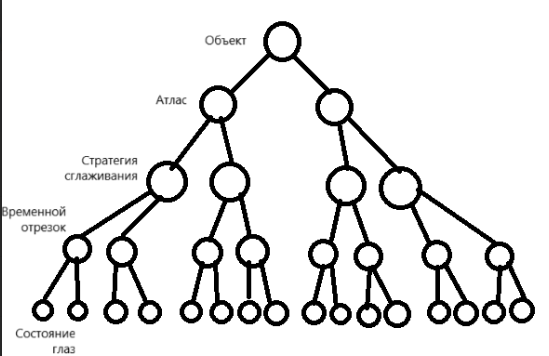

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.filterwarnings('ignore')

# Данные

In [ ]:
data = np.load('ihb.npy')
common_brain_region_data = data[:, :, 0]

reshaped_data = data.reshape(-1, 246)

time_stamps = np.tile(np.arange(10), 320)
observation_indices = np.repeat(np.arange(320), 10)

df = pd.DataFrame(reshaped_data)
df['Observation'] = observation_indices
df['TimeStamp'] = time_stamps
df = df[['Observation', 'TimeStamp'] + list(df.columns[:-2])]

df.iloc[8:12,:]

,Observation,TimeStamp,0,1,2,3,4,5,6,7,...,236,237,238,239,240,241,242,243,244,245
8,0,8,-0.205547,-0.051674,0.090928,-0.198751,-0.592191,-0.579343,-0.158702,-0.275901,...,-0.286233,2.025021,-1.760223,-0.240860,-1.282186,-3.348719,-1.914329,-2.408028,0.514306,-1.150618
9,0,9,0.786760,-0.050273,-0.314628,-0.105127,-1.028900,-0.836180,0.321946,1.120566,...,-1.212765,0.268647,-0.544721,-0.900018,0.909275,1.529439,-0.137910,0.445667,-0.625245,-1.261869
10,1,0,1.023895,-0.176682,-0.811669,0.536139,-2.515479,2.121760,1.785636,-0.711601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,1,1,-0.929717,-0.322515,-0.705983,-1.975086,1.490381,-1.202225,-0.313915,-0.233086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Разбиение по атласам

У разных атласов разное количество признаков

In [ ]:
df_brain = df[~df.isna().any(axis=1)].iloc[:,2:]
df_s200 = df[df.isna().any(axis=1)].iloc[:,2:].dropna(axis=1)
df_s200

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
10,1.023895,-0.176682,-0.811669,0.536139,-2.515479,2.121760,1.785636,-0.711601,-0.607609,1.411412,...,0.043493,0.244985,0.003254,-0.762333,-2.212562,-0.543139,-1.638934,0.620223,-1.204378,-0.052519
11,-0.929717,-0.322515,-0.705983,-1.975086,1.490381,-1.202225,-0.313915,-0.233086,0.432752,-0.940389,...,-1.717170,-0.173238,0.451710,0.069003,-0.392096,0.051546,-0.656602,-0.199138,-0.473937,-0.199703
12,-0.341629,0.131138,0.155059,0.745065,-0.315335,-1.253238,0.331082,0.023791,-0.780040,1.752312,...,0.621228,1.196949,-0.652698,1.037204,1.040373,1.061813,1.245755,1.618342,1.089889,0.205204
13,1.711881,2.160387,1.777172,1.382157,3.139590,1.597457,1.912726,0.676146,1.593602,1.559462,...,1.387639,0.336699,0.025700,-0.003658,-0.467651,-0.576101,-0.269088,2.053298,0.097042,0.414169
14,0.568950,-0.043495,0.678210,0.901174,1.135003,0.339475,-0.919318,0.860605,0.604444,-0.300989,...,-3.150525,-2.158298,-0.350300,-1.016435,0.423600,-0.693803,0.353542,-0.463910,1.297040,0.685382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,-0.588822,-0.701177,-0.576556,-0.475991,-1.615566,0.855666,-0.862559,-0.338000,-0.340812,-0.644001,...,0.363303,0.384910,0.106555,-0.991261,-1.782958,-0.214089,-1.376996,-1.492860,-0.917963,-1.438078
3186,0.305583,-0.544903,-0.867562,-0.596519,-0.343004,1.607527,0.179306,-0.226929,-0.345255,0.767960,...,0.686904,0.631937,-0.143940,1.199992,1.668142,0.423933,1.415170,1.817624,1.329383,2.017529
3187,-0.528072,0.062244,1.137930,-0.149651,0.631545,-0.947695,0.287410,0.682996,-0.156513,-0.336837,...,-1.468656,-1.535458,-1.277127,-0.102608,1.732966,1.587565,0.838632,-2.088158,-0.390097,0.213473
3188,0.694622,0.362979,0.005653,1.195485,-0.425003,0.054787,0.616057,0.267031,0.425677,0.420645,...,-0.349298,-0.678259,-0.532298,-0.982517,-0.326822,-1.130645,-0.237658,-0.754260,-0.670364,-2.251999


In [ ]:
df_s200 = df[df.isna().any(axis=1)].loc[:,:199]
df_s200

,Observation,TimeStamp,0,1,2,3,4,5,6,7,...,190,191,192,193,194,195,196,197,198,199
10,1,0,1.023895,-0.176682,-0.811669,0.536139,-2.515479,2.121760,1.785636,-0.711601,...,0.043493,0.244985,0.003254,-0.762333,-2.212562,-0.543139,-1.638934,0.620223,-1.204378,-0.052519
11,1,1,-0.929717,-0.322515,-0.705983,-1.975086,1.490381,-1.202225,-0.313915,-0.233086,...,-1.717170,-0.173238,0.451710,0.069003,-0.392096,0.051546,-0.656602,-0.199138,-0.473937,-0.199703
12,1,2,-0.341629,0.131138,0.155059,0.745065,-0.315335,-1.253238,0.331082,0.023791,...,0.621228,1.196949,-0.652698,1.037204,1.040373,1.061813,1.245755,1.618342,1.089889,0.205204
13,1,3,1.711881,2.160387,1.777172,1.382157,3.139590,1.597457,1.912726,0.676146,...,1.387639,0.336699,0.025700,-0.003658,-0.467651,-0.576101,-0.269088,2.053298,0.097042,0.414169
14,1,4,0.568950,-0.043495,0.678210,0.901174,1.135003,0.339475,-0.919318,0.860605,...,-3.150525,-2.158298,-0.350300,-1.016435,0.423600,-0.693803,0.353542,-0.463910,1.297040,0.685382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,318,5,-0.588822,-0.701177,-0.576556,-0.475991,-1.615566,0.855666,-0.862559,-0.338000,...,0.363303,0.384910,0.106555,-0.991261,-1.782958,-0.214089,-1.376996,-1.492860,-0.917963,-1.438078
3186,318,6,0.305583,-0.544903,-0.867562,-0.596519,-0.343004,1.607527,0.179306,-0.226929,...,0.686904,0.631937,-0.143940,1.199992,1.668142,0.423933,1.415170,1.817624,1.329383,2.017529
3187,318,7,-0.528072,0.062244,1.137930,-0.149651,0.631545,-0.947695,0.287410,0.682996,...,-1.468656,-1.535458,-1.277127,-0.102608,1.732966,1.587565,0.838632,-2.088158,-0.390097,0.213473
3188,318,8,0.694622,0.362979,0.005653,1.195485,-0.425003,0.054787,0.616057,0.267031,...,-0.349298,-0.678259,-0.532298,-0.982517,-0.326822,-1.130645,-0.237658,-0.754260,-0.670364,-2.251999


#  Разбиение по стратегиям сглаживания

In [ ]:
reshaped_df = pd.DataFrame(df.loc[:, 0:].values.reshape(320, 2460))
reshaped_df.index = range(reshaped_df.shape[0])
reshaped_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2450,2451,2452,2453,2454,2455,2456,2457,2458,2459
0,-1.208052,0.111388,-0.234515,0.365944,1.505549,1.324777,-0.949294,-0.981606,-1.149822,-0.546311,...,-1.212765,0.268647,-0.544721,-0.900018,0.909275,1.529439,-0.137910,0.445667,-0.625245,-1.261869
1,1.023895,-0.176682,-0.811669,0.536139,-2.515479,2.121760,1.785636,-0.711601,-0.607609,1.411412,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.817854,0.556707,1.002281,1.291516,1.178712,0.800441,0.640770,0.708481,-0.036083,-0.447398,...,1.938090,2.713526,1.280674,-1.244978,0.558913,-1.107115,0.164691,0.821017,1.607977,-0.331827
3,-0.373658,-0.102926,-0.128723,-0.526620,-1.105195,-1.329006,-0.215083,-0.624067,-0.676118,-0.674147,...,-1.098890,-1.437548,1.140226,-0.971621,0.170208,-0.721462,-1.036253,-0.847981,0.335714,0.438046
4,0.413069,0.198817,1.553243,-0.205627,-1.076309,-1.131250,-0.144148,0.725243,-0.104612,-0.271953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_brain = reshaped_df[~reshaped_df.isna().any(axis=1)]
df_s200 = reshaped_df[reshaped_df.isna().any(axis=1)].dropna(axis=1)

reshaped_brain_df = pd.DataFrame(df_brain).transpose()
reshaped_s200_df = pd.DataFrame(df_s200).transpose()

Для атласа Brainnetome

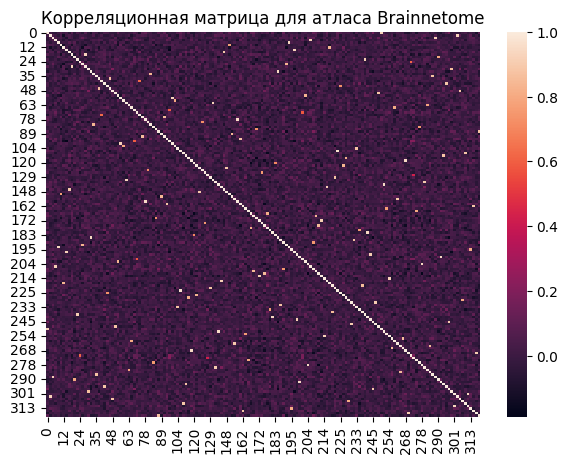

In [ ]:
df_for_corr = reshaped_brain_df

fig, ax = plt.subplots(figsize=(7, 5))
plt.title('Корреляционная матрица для атласа Brainnetome')
sns.heatmap(df_for_corr.corr(), fmt='.2g');

Отчетливо видно что каждый объект хорошо коррелирует с одним из объектов

In [ ]:
def get_correlated_features(corr_matrix, feat_stats=None, greater_is_better=True, corr_threshold=0.9, printing=True):
    correlated_features = set()
    corr_pairs = []

    for col in tqdm.tqdm(corr_matrix.columns, desc='Выявление коррелированных объектов'):
        if col in correlated_features:
            continue

        correlated_cols = corr_matrix.index[np.abs(corr_matrix[col]) >= corr_threshold].tolist()

        if len(correlated_cols) > 1:
            if printing:
                print(f'{col} -> {correlated_cols}')
            corr_pairs.append(correlated_cols)
            correlated_features.update(correlated_cols[1:])

    return list(correlated_features), list(corr_pairs)

In [ ]:
corr_mx = pd.DataFrame(np.corrcoef(df_for_corr.values, rowvar=False),
                       columns=df_for_corr.columns,
                       index=df_for_corr.columns)

corr_features, corr_pairs = get_correlated_features(corr_mx,
                                                    corr_threshold=0.4)
print('______________________________')
print(f'Коррелированные объекты \n{corr_features},\nКоличество: {len(corr_features)}')

Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 160/160 [00:00<00:00, 8673.31it/s]

0 -> [0, 248]
2 -> [2, 302]
3 -> [3, 287]
6 -> [6, 205]
7 -> [7, 191]
11 -> [11, 149]
12 -> [12, 216]
14 -> [14, 196]
19 -> [19, 142]
20 -> [20, 29]
21 -> [21, 290]
23 -> [23, 241]
24 -> [24, 270]
27 -> [27, 189]
31 -> [31, 299]
32 -> [32, 186]
34 -> [34, 82]
35 -> [35, 286]
37 -> [37, 46]
41 -> [41, 72]
42 -> [42, 294]
45 -> [45, 225]
48 -> [48, 303]
49 -> [49, 247]
50 -> [50, 203]
52 -> [52, 100]
56 -> [56, 101]
62 -> [62, 130]
63 -> [63, 283]
65 -> [65, 257]
68 -> [68, 96]
71 -> [71, 200]
76 -> [76, 91]
78 -> [78, 156]
80 -> [80, 125]
83 -> [83, 275]
85 -> [85, 171]
87 -> [87, 319]
89 -> [89, 151]
95 -> [95, 158]
104 -> [104, 233]
108 -> [108, 223]
113 -> [113, 306]
114 -> [114, 292]
117 -> [117, 227]
118 -> [118, 268]
120 -> [120, 183]
121 -> [121, 226]
122 -> [122, 148]
126 -> [126, 174]
127 -> [127, 271]
129 -> [129, 221]
134 -> [134, 282]
137 -> [137, 251]
139 -> [139, 215]
152 -> [152, 261]
162 -> [162, 315]
164 -> [164, 252]
166 -> [166, 273]
167 -> [167, 176]
168 -> [168, 209

Для атласа Schaefer200

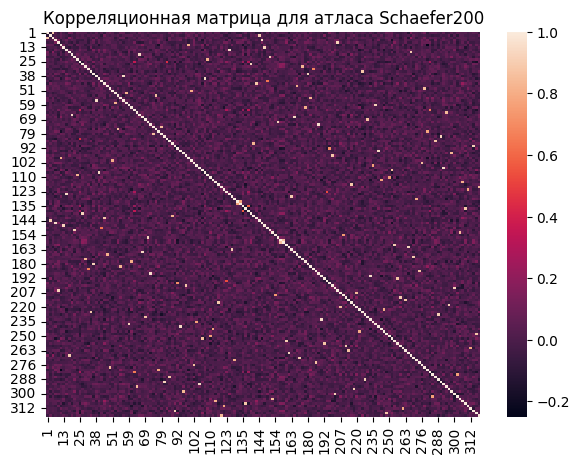

In [ ]:
df_for_corr = reshaped_s200_df

fig, ax = plt.subplots(figsize=(7, 5))
plt.title('Корреляционная матрица для атласа Schaefer200')
sns.heatmap(df_for_corr.corr(), fmt='.2g');

Аналогичная ситуация

In [ ]:
corr_mx = pd.DataFrame(np.corrcoef(df_for_corr.values, rowvar=False),
                       columns=df_for_corr.columns,
                       index=df_for_corr.columns)

corr_features, corr_pairs = get_correlated_features(corr_mx,
                                                    corr_threshold=0.4)
print('______________________________')
print(f'Коррелированные объекты \n{corr_features},\nКоличество: {len(corr_features)}')

Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 160/160 [00:00<00:00, 8044.41it/s]

1 -> [1, 5]
4 -> [4, 144]
8 -> [8, 145]
9 -> [9, 202]
10 -> [10, 98]
13 -> [13, 146]
15 -> [15, 124]
16 -> [16, 265]
17 -> [17, 66]
18 -> [18, 150]
22 -> [22, 109]
25 -> [25, 84]
26 -> [26, 140]
28 -> [28, 173]
30 -> [30, 182]
33 -> [33, 224]
36 -> [36, 180]
38 -> [38, 57]
39 -> [39, 107]
40 -> [40, 147]
43 -> [43, 143]
44 -> [44, 169]
47 -> [47, 277]
51 -> [51, 99]
53 -> [53, 58]
54 -> [54, 75]
55 -> [55, 181]
59 -> [59, 237]
60 -> [60, 177]
61 -> [61, 280]
64 -> [64, 296]
67 -> [67, 165]
69 -> [69, 231]
70 -> [70, 155]
73 -> [73, 185]
74 -> [74, 79]
77 -> [77, 279]
81 -> [81, 289]
86 -> [86, 285]
88 -> [88, 141]
90 -> [90, 314]
92 -> [92, 194]
93 -> [93, 239]
94 -> [94, 298]
97 -> [97, 199]
102 -> [102, 276]
103 -> [103, 235]
105 -> [105, 293]
106 -> [106, 253]
110 -> [110, 250]
111 -> [111, 240]
112 -> [112, 309]
115 -> [115, 217]
116 -> [116, 318]
119 -> [119, 311]
123 -> [123, 193]
128 -> [128, 163]
131 -> [131, 272]
132 -> [132, 133]
135 -> [135, 138]
136 -> [136, 310]
153 -> [15

In [ ]:
# получившиеся коррелированные объекты

corr_pairs_brain = [[0, 248], [2, 302], [3, 287], [6, 205], [7, 191], [11, 149], [12, 216], [14, 196],
                    [19, 142], [20, 29], [21, 290], [23, 241], [24, 270], [27, 189], [31, 299], [32, 186],
                    [34, 82], [35, 286], [37, 46], [41, 72], [42, 294], [45, 225], [48, 303], [49, 247],
                    [50, 203], [52, 100], [56, 101], [62, 130], [63, 283], [65, 257], [68, 96], [71, 200],
                    [76, 91], [78, 156], [80, 125], [83, 275], [85, 171], [87, 319], [89, 151], [95, 158],
                    [104, 233], [108, 223], [113, 306], [114, 292], [117, 227], [118, 268], [120, 183],
                    [121, 226], [122, 148], [126, 174], [127, 271], [129, 221], [134, 282], [137, 251],
                    [139, 215], [152, 261], [162, 315], [164, 252], [166, 273], [167, 176], [168, 209],
                    [172, 213], [175, 210], [178, 236], [179, 243], [187, 232], [188, 206], [195, 313],
                    [197, 244], [198, 291], [204, 278], [214, 254], [218, 238], [228, 305], [230, 246],
                    [245, 295], [256, 267], [262, 284], [269, 317], [301, 308]]

corr_pairs_s200 = [[1, 5], [4, 144], [8, 145], [9, 202], [10, 98], [13, 146], [15, 124], [16, 265], [17, 66],
                   [18, 150], [22, 109], [25, 84], [26, 140], [28, 173], [30, 182], [33, 224], [36, 180],
                   [38, 57], [39, 107], [40, 147], [43, 143], [44, 169], [47, 277], [51, 99], [53, 58],
                   [54, 75], [55, 181], [59, 237], [60, 177], [61, 280], [64, 296], [67, 165], [69, 231],
                   [70, 155], [73, 185], [74, 79], [77, 279], [81, 289], [86, 285], [88, 141], [90, 314],
                   [92, 194], [93, 239], [94, 298], [97, 199], [102, 276], [103, 235], [105, 293], [106, 253],
                   [110, 250], [111, 240], [112, 309], [115, 217], [116, 318], [119, 311], [123, 193], [128, 163],
                   [131, 272], [132, 133], [135, 138], [136, 310], [153, 307], [154, 208], [157, 159], [160, 255],
                   [161, 264], [170, 266], [184, 274], [190, 234], [192, 258], [201, 300], [207, 220], [211, 259],
                   [212, 263], [219, 297], [222, 242], [229, 288], [249, 316], [260, 312], [281, 304]]

# выделение по одному объекту из каждой пары
corr_objects_brain = [29, 46, 72, 82, 91, 96, 100, 101, 125, 130, 142, 148, 149, 151, 156, 158, 171, 174,
                      176, 183, 186, 189, 191, 196, 200, 203, 205, 206, 209, 210, 213, 215, 216, 221, 223,
                      225, 226, 227, 232, 233, 236, 238, 241, 243, 244, 246, 247, 248, 251, 252, 254, 257,
                      261, 267, 268, 270, 271, 273, 275, 278, 282, 283, 284, 286, 287, 290, 291, 292, 294,
                      295, 299, 302, 303, 305, 306, 308, 313, 315, 317, 319]

corr_objects_s_200 = [5, 57, 58, 66, 75, 79, 84, 98, 99, 107, 109, 124, 133, 138, 140, 141, 143, 144,
                      145, 146, 147, 150, 155, 159, 163, 165, 169, 173, 177, 180, 181, 182, 185, 193,
                      194, 199, 202, 208, 217, 220, 224, 231, 234, 235, 237, 239, 240, 242, 250, 253,
                      255, 258, 259, 263, 264, 265, 266, 272, 274, 276, 277, 279, 280, 285, 288, 289,
                      293, 296, 297, 298, 300, 304, 307, 309, 310, 311, 312, 314, 316, 318]

# Разбиение по временным отрезкам

In [ ]:
# Создание csv файлов, для простоты использования в других ноутбуках

# df_brain_sm1 = df_brain.loc[corr_objects_brain, :]
# df_brain_sm2 = df_brain.drop(corr_objects_brain, axis=0)

# df_s200_sm1 = df_s200.loc[corr_objects_s_200, :]
# df_s200_sm2 = df_s200.drop(corr_objects_s_200, axis=0)

# df_brain_sm1.to_csv('df_brain_sm1.csv', index=False)
# df_brain_sm2.to_csv('df_brain_sm2.csv', index=False)

# df_s200_sm1.to_csv('df_s200_sm1.csv', index=False)
# df_s200_sm2.to_csv('df_s200_sm2.csv', index=False)

In [ ]:
df_brain_sm1 = pd.read_csv('df_brain_sm1.csv', index_col=0)
df_brain_sm2 = pd.read_csv('df_brain_sm2.csv', index_col=0)

df_s200_sm1 = pd.read_csv('df_s200_sm1.csv', index_col=0)
df_s200_sm2 = pd.read_csv('df_s200_sm2.csv', index_col=0)

Для начала рассмотрим временные последовательности

In [ ]:
df_brain = df[~df.isna().any(axis=1)].iloc[:,2:]
df_brain_resh = reshaped_df[~reshaped_df.isna().any(axis=1)]

num_measurements = 10  #10 временных измерений на объект
num_objects = len(df_brain) // num_measurements  #Количество объектов
df_ = df_brain

reshaped_data = []
for i in range(num_objects):
    # Извлекаем 10 строк (измерений) для одного объекта
    block = df_.iloc[i * num_measurements:(i + 1) * num_measurements].T  # Транспонируем

    # Преобразуем строки, чтобы для каждого признака было по 10 измерений подряд
    reshaped_row = block.values.flatten()

    # Добавляем полученную строку в новый список
    reshaped_data.append(reshaped_row)

df_transformed = pd.DataFrame(reshaped_data)
df_transformed.index = df_brain_resh.index
df_transformed_brain_sm1 = df_transformed.loc[df_brain_sm1.index]
df_transformed_brain_sm1.head()

,0,1,2,3,4,5,6,7,8,9,...,2450,2451,2452,2453,2454,2455,2456,2457,2458,2459
29,-0.757747,-2.484975,-2.061261,0.488030,-0.516502,-0.345156,-0.564263,-0.106822,0.778068,0.845678,...,-0.324897,-0.148267,0.220190,-0.181217,-0.405425,1.333884,-0.044330,0.071544,-0.178250,0.149651
46,-1.020438,-0.712927,-0.309403,0.701630,1.130122,0.096812,0.640869,-0.565827,-0.141989,-1.275529,...,-1.199604,0.122756,0.546863,-1.007105,-0.975615,0.775755,0.146364,-0.493368,0.716418,-0.962115
72,-1.304438,-0.413533,0.260586,-0.195568,-0.800504,1.402855,0.964236,1.789505,-1.280978,-1.055694,...,-0.423746,-0.038689,0.731355,-1.189710,0.939223,-0.073926,-0.148117,0.772832,-0.198597,-0.797324
82,0.582237,0.725223,-1.902599,0.063160,-1.270111,1.083565,0.334018,-0.590835,1.050881,1.398562,...,0.217684,-0.820595,-0.569019,0.178390,0.930809,0.219901,0.121675,-0.590319,-0.207726,0.662974
91,-0.178499,-0.980964,-0.069809,0.773421,1.013486,-0.952658,0.071268,-0.186159,-0.653678,0.594255,...,0.050503,-0.827735,0.123631,0.819649,-0.338201,0.300224,0.448400,-0.073025,0.185875,-0.402701


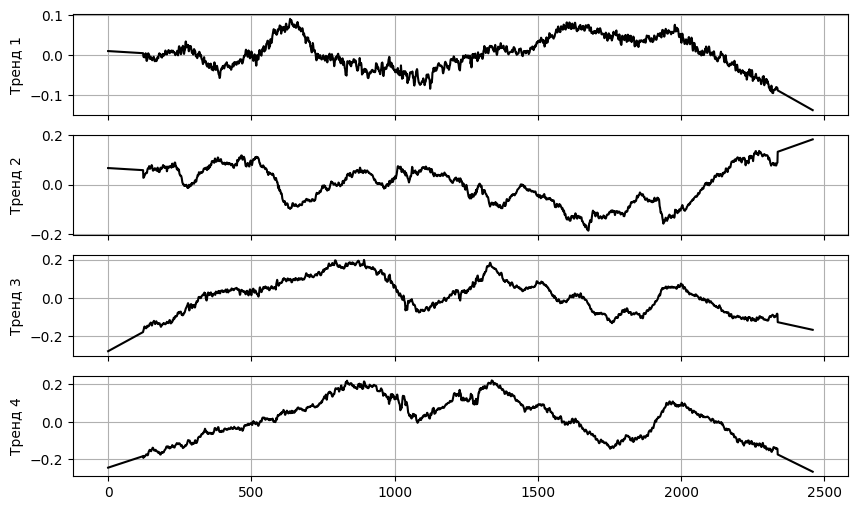

In [ ]:
# Рассмотрим временные тренды для некоторых объектов

ind_list = [125, 130, 29,223]
i = ind_list[0]
j = ind_list[1]
k = ind_list[2]
l = ind_list[3]

dataset_sd = seasonal_decompose(df_transformed_brain_sm1.loc[i,:], model='additive', period=246, extrapolate_trend='freq')
dataset_sd_1 = seasonal_decompose(df_transformed_brain_sm1.loc[j,:], model='additive', period=246, extrapolate_trend='freq')
dataset_sd_2 = seasonal_decompose(df_transformed_brain_sm1.loc[k,:], model='additive', period=246, extrapolate_trend='freq')
dataset_sd_3 = seasonal_decompose(df_transformed_brain_sm1.loc[l,:], model='additive', period=246, extrapolate_trend='freq')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10,6))

dataset_sd.trend.plot(ax=axes[0], legend=False, color='black')
axes[0].set_ylabel('Тренд 1')
axes[0].grid()

dataset_sd_1.trend.plot(ax=axes[1], legend=False, color='black')
axes[1].set_ylabel('Тренд 2')
axes[1].grid()

dataset_sd_2.trend.plot(ax=axes[2], legend=False, color='black')
axes[2].set_ylabel('Тренд 3')
axes[2].grid()

dataset_sd_3.trend.plot(ax=axes[3], legend=False, color='black')
axes[3].set_ylabel('Тренд 4')
axes[3].grid()

plt.show()

Судя по временным трендам можно сказать, что одинаковые объекты могут иметь схожий тренд, а значит схожее стандартное отклонение в данных

In [ ]:
df_brain_sm1_res = pd.DataFrame(df_brain_sm1.values.reshape(800, 246))

In [ ]:
def process_data_std(df, df_father, range_=246):
    dict_tail_head = {}
    for i in range(80):
        vols = []
        for column in range(range_):  # 246 измерений по каждому объекту
            vol = df.iloc[10*i:(i+1)*10, column].std()  # стандартное отклонение блока
            vols.append(vol)

        dict_tail_head[i] = vols

    total_columns = range_
    result_df = pd.DataFrame.from_dict(dict_tail_head, orient='index', columns=[i for i in range(total_columns)])
    result_df.index = df_father.index
    return result_df

df_std = process_data_std(df_brain_sm1_res, df_brain_sm1)

df_std.head()

,0,1,2,3,4,5,6,7,8,9,...,236,237,238,239,240,241,242,243,244,245
29,1.107550,0.731348,0.643669,0.760345,1.161825,1.025086,0.484615,0.636064,0.566176,0.733822,...,0.817852,1.270110,0.815971,1.097139,1.331762,1.327523,1.282849,0.616060,0.511982,0.493225
46,0.788102,0.601738,0.506983,0.603359,1.075234,0.672884,0.580198,0.409519,0.859126,0.804898,...,1.035855,1.848357,0.486130,0.878038,0.842973,1.048294,1.595613,1.909318,0.721881,0.780462
72,1.127183,0.791498,0.437890,0.530025,0.654311,0.598951,0.483861,0.515784,0.853999,0.399545,...,1.221964,1.292410,0.440561,1.253756,1.134459,1.365655,0.723087,0.666054,0.698464,0.690822
82,1.084220,0.784934,0.757885,0.763602,1.366083,1.250898,0.570273,1.193694,0.716234,1.054990,...,1.342966,1.596633,0.503392,0.550518,0.718633,0.663955,1.391615,1.776494,0.724009,0.561251
91,0.692794,0.439497,0.860337,0.568928,0.859876,0.792989,0.555315,0.868221,0.762078,0.763993,...,0.928316,1.481933,0.741003,0.795626,1.002806,1.117231,0.989899,0.912981,0.412434,0.468356


In [ ]:
def get_corr_df(df: pd.DataFrame, df_father: pd.DataFrame):
    corr_values = []
    for i in range(80):
        df_for_corr = df.iloc[:, i*10:(i*10+10)]
        corr_matrix = df_for_corr.corr().values
        triu_indices = np.triu_indices(corr_matrix.shape[0], k=1)
        upper_triangle = corr_matrix[triu_indices]
        corr_values.append(upper_triangle)

    corr_df = pd.DataFrame(corr_values, index=df_father.index)
    return corr_df

In [ ]:
def equal_corr(df_for_corr):
    sum_corr = 0
    max_corr_list = []  # Список для хранения (i, j, значение корреляции)

    # Проход по каждому элементу в матрице корреляции
    for i, corr_matrix in enumerate(df_for_corr.values):
        for j, corr_matrix_2 in enumerate(df_for_corr.values):
            if i != j:  # Пропускаем случай, когда i == j
                corr_value = np.corrcoef(corr_matrix, corr_matrix_2)[0][1]
                # Сохраняем i, j и корреляцию в список для последующей обработки
                max_corr_list.append((df_for_corr.index[i], df_for_corr.index[j], corr_value))

    # Сортируем список по абсолютной величине корреляции по убыванию
    max_corr_list.sort(key=lambda x: abs(x[2]), reverse=True)

    # Множество для отслеживания задействованных объектов
    used_indices = set()
    final_corr_dict = {}

    # Проходим по отсортированному списку пар и добавляем непересекающиеся пары
    for i, j, corr_value in max_corr_list:
        if i not in used_indices and j not in used_indices:
            final_corr_dict[i] = j
            used_indices.add(i)
            used_indices.add(j)
            sum_corr += corr_value

    # Проверка, что все объекты задействованы
    remaining_indices = set(df_for_corr.index) - used_indices
    if remaining_indices:
        print(f"Предупреждение: следующие объекты не задействованы: {remaining_indices}")

    print(f'Sum corr {sum_corr}')
    return final_corr_dict, sum_corr

In [ ]:
# Определние оптимального количества признаков

df_std_paired = df_std
std_top_ = df_std_paired.std().sort_values(ascending=False)
list_std_and_corr = []
for i in range(20, 60):
    df_std_top_ = df_std_paired.loc[:,std_top_.head(i).index.values]
    corr_count = equal_corr(df_std_top_)[1]
    list_std_and_corr.append((i, corr_count))
    print((i, corr_count))

Sum corr 31.487253217522824
(20, 31.487253217522824)
Sum corr 31.229569616690096
(21, 31.229569616690096)
Sum corr 31.036960208815007
(22, 31.036960208815007)
Sum corr 30.99688038066488
(23, 30.99688038066488)
Sum corr 30.50126506412453
(24, 30.50126506412453)
Sum corr 30.9551901411287
(25, 30.9551901411287)
Sum corr 30.873719842013458
(26, 30.873719842013458)
Sum corr 30.936159873403106
(27, 30.936159873403106)
Sum corr 30.85191156302646
(28, 30.85191156302646)
Sum corr 30.965640574600982
(29, 30.965640574600982)
Sum corr 31.0691838669223
(30, 31.0691838669223)
Sum corr 31.15806175598968
(31, 31.15806175598968)
Sum corr 30.849232871428
(32, 30.849232871428)
Sum corr 30.83618946114607
(33, 30.83618946114607)
Sum corr 30.816971634494884
(34, 30.816971634494884)
Sum corr 30.760691344737058
(35, 30.760691344737058)
Sum corr 31.173914056458564
(36, 31.173914056458564)
Sum corr 30.876552328364095
(37, 30.876552328364095)
Sum corr 30.885187475351138
(38, 30.885187475351138)
Sum corr 31.23332

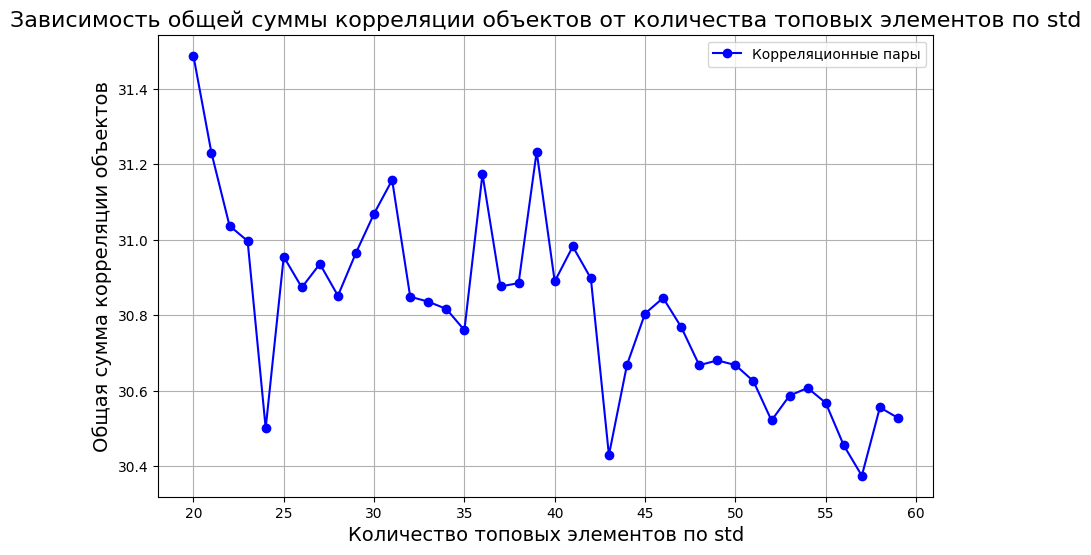

In [ ]:
x_values = [x[0] for x in list_std_and_corr]
y_values = [x[1] for x in list_std_and_corr]

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label='Корреляционные пары')

plt.title('Зависимость общей суммы корреляции объектов от количества топовых элементов по std', fontsize=16)
plt.xlabel('Количество топовых элементов по std', fontsize=14)
plt.ylabel('Общая сумма корреляции объектов', fontsize=14)

plt.grid(True)
plt.legend()

plt.show()

Видно, что для 39 лучших std лучше всего сохраняется баланс данных и суммы корреляции, поэтому выберем его

In [ ]:
# Разбиение на группы по времени

df_std = process_data_std(df_brain_sm1_res, df_brain_sm1)

std_top_head = df_std.std().sort_values(ascending=False).head(39)
df_std_top_head = df_std.loc[:,std_top_head.index.values]

df_std_top_equaled = equal_corr(df_std_top_head)[0]
group_std_1 = list(df_std_top_equaled.keys())
group_std_2 = list(df_std_top_equaled.values())
print(group_std_1)
print(group_std_2)

Sum corr 31.23332780035283
[221, 226, 151, 171, 254, 100, 183, 216, 241, 233, 191, 91, 156, 236, 209, 275, 317, 210, 206, 205, 248, 203, 306, 286, 125, 223, 174, 196, 284, 270, 278, 225, 130, 148, 189, 200, 46, 82, 238, 244]
[232, 257, 213, 227, 96, 261, 295, 308, 294, 271, 246, 149, 299, 290, 283, 186, 29, 303, 315, 251, 319, 252, 101, 267, 215, 282, 247, 268, 291, 72, 302, 176, 142, 243, 313, 273, 292, 158, 305, 287]


# Разделение по состоянию глаз

In [ ]:
df_brain_sm1_unresh = pd.DataFrame(df_brain_sm1.values.reshape(800, 246)).transpose()
df_s200_sm1_unresh = pd.DataFrame(df_s200_sm1.values.reshape(800, 200)).transpose()

df_brain_sm2_unresh = pd.DataFrame(df_brain_sm2.values.reshape(800, 246)).transpose()
df_s200_sm2_unresh = pd.DataFrame(df_s200_sm2.values.reshape(800, 200)).transpose()

In [ ]:
df_brain_sm1_corr = get_corr_df(df_brain_sm1_unresh, df_brain_sm1)
df_s200_sm1_corr = get_corr_df(df_s200_sm1_unresh, df_s200_sm1)
df_brain_sm2_corr = get_corr_df(df_brain_sm2_unresh, df_brain_sm2)
df_s200_sm2_corr = get_corr_df(df_s200_sm2_unresh, df_s200_sm2)

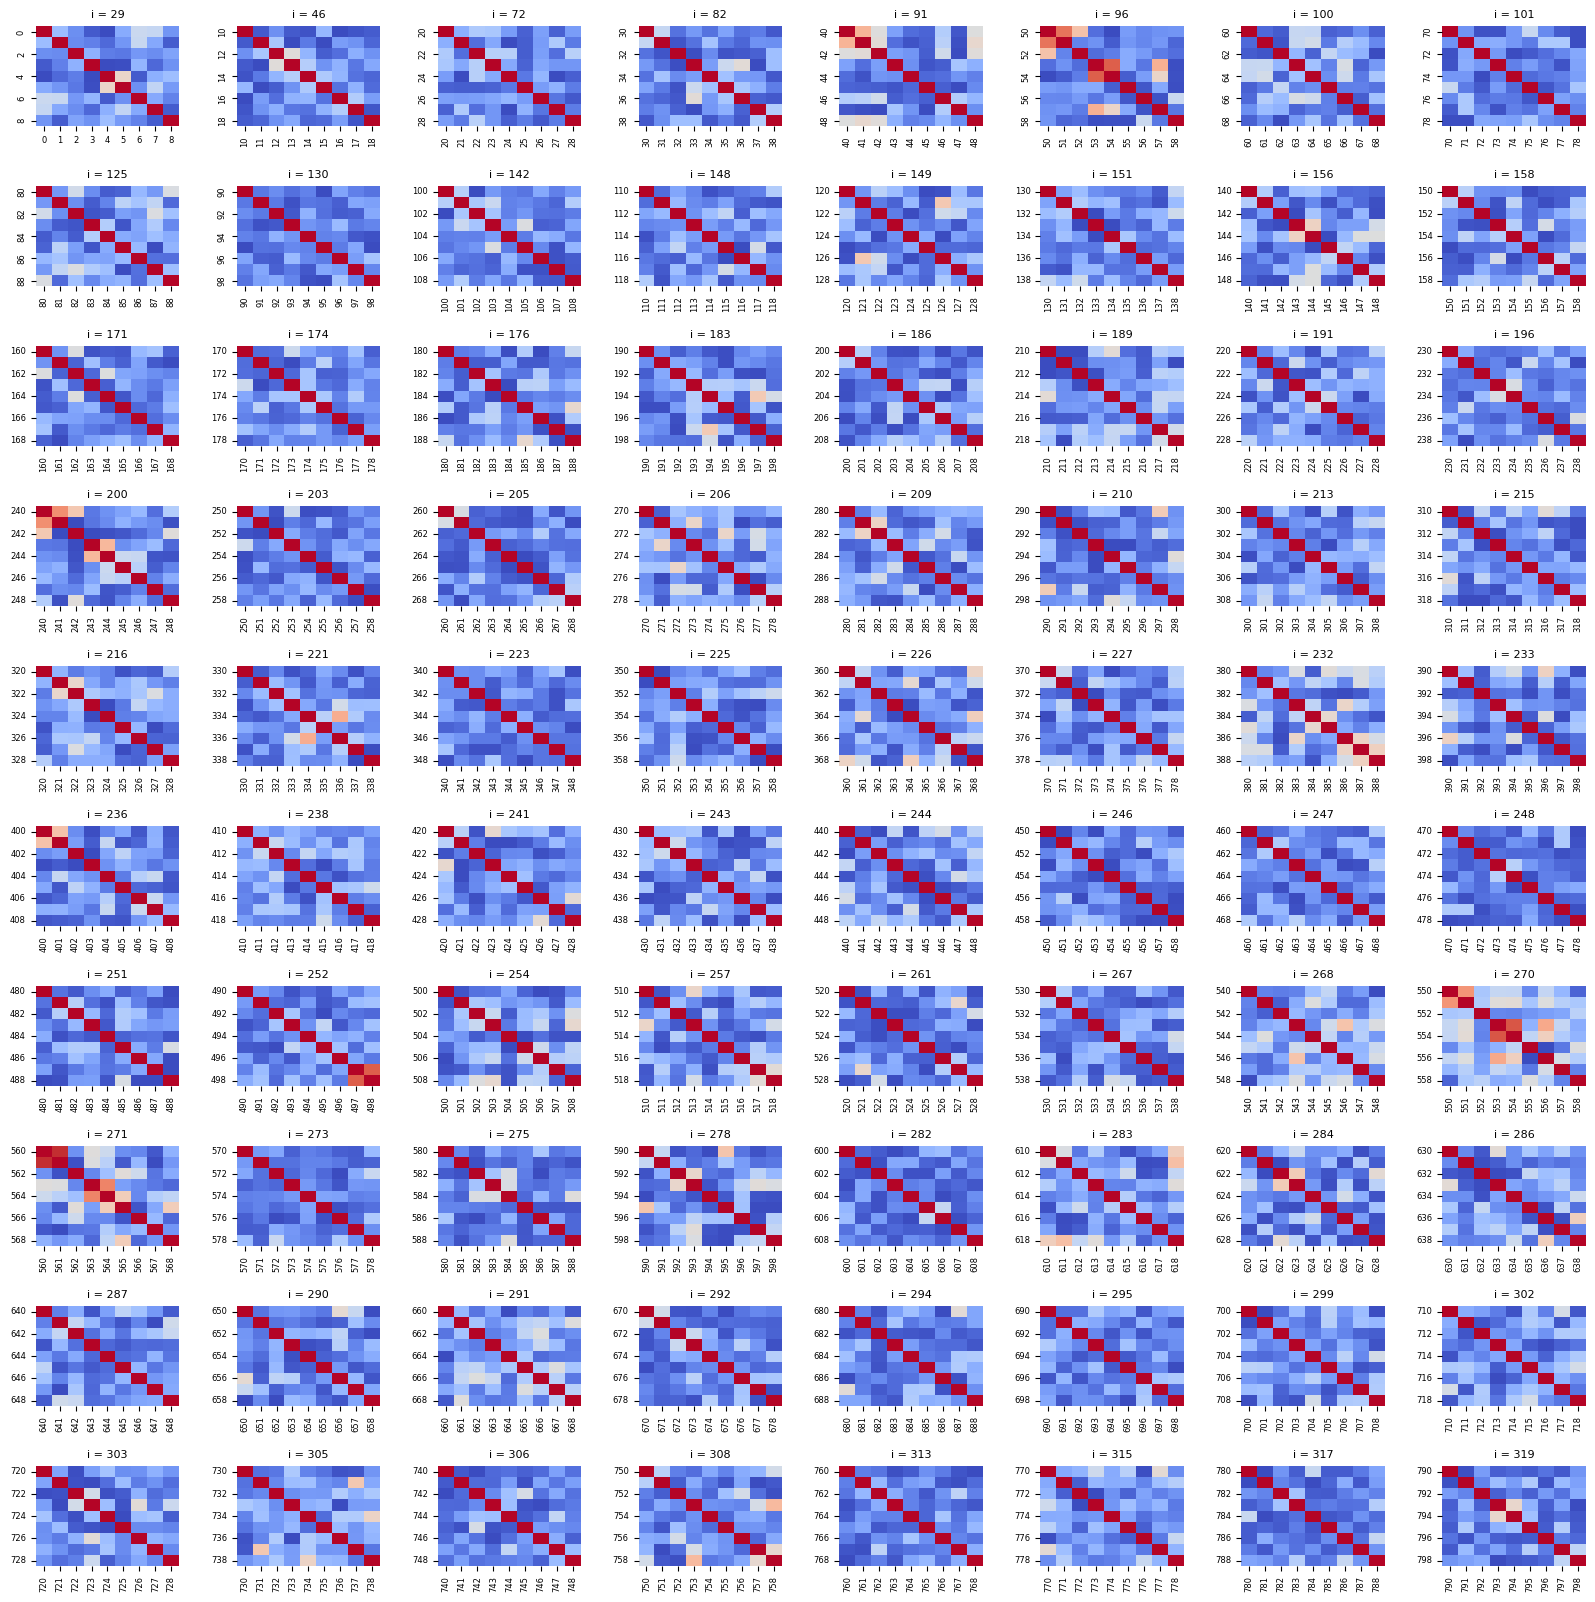

In [ ]:
# Рассмотрим корреляцию признаков во времени для каждого объекта

dataset = df_brain_sm1_unresh
df_for_index = df_brain_sm1

n_rows, n_cols = 10, 8
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for i in range(80):
    row, col = divmod(i, n_cols)
    df_for_corr = dataset.iloc[:,i*10:i*10+9]
    sns.heatmap(abs(df_for_corr.corr()), fmt='.2g', ax=axes[row, col], cmap='coolwarm', cbar=False)

    axes[row, col].set_title(f'i = {df_for_index.index[i]}', fontsize=8)
    axes[row, col].tick_params(axis='both', which='major', labelsize=6)

plt.show()

Можно заметить схожие структуры

In [ ]:
def filter_dataframe_by_columns(df, corr_obj):
    # Исключаем столбцы, указанные в corr_obj
    filtered_df = df.transpose().drop(corr_obj, axis=1).transpose()
    return filtered_df

In [ ]:
# Подбор отпимального порога отсечения для коррелированных признаков

df_for_corr = df_brain_sm1_unresh.transpose()

corr_mx = pd.DataFrame(np.corrcoef(df_for_corr.values, rowvar=False),
                       columns=df_for_corr.columns,
                       index=df_for_corr.columns)

df_brain_sm1_unresh.columns = df_brain_sm1_unresh.columns.astype(int)
list_of_max_corrs = []
for corr_thres in np.linspace(0.4, 0.5, 200):
    corr_features, corr_pairs = get_correlated_features(corr_mx,
                                                        corr_threshold=corr_thres,
                                                        printing=False
                                                       )

    filtered_df = filter_dataframe_by_columns(df_brain_sm1_unresh, corr_features)
    corr_filtred_dataset = get_corr_df(filtered_df, df_brain_sm1)
    max_corr_d_1, sum_c = equal_corr(corr_filtred_dataset.loc[group_std_1])
    max_corr_d_2, sum_c_2 = equal_corr(corr_filtred_dataset.loc[group_std_2])
    list_of_max_corrs.append((sum_c+sum_c_2, corr_thres))
    print(list_of_max_corrs[-1])

Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 8854.13it/s]


Sum corr 4.044510683993603
Sum corr 6.126461837923421
(10.170972521917024, 0.4)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12304.56it/s]


Sum corr 4.044510683993603
Sum corr 6.126461837923421
(10.170972521917024, 0.4005025125628141)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11587.91it/s]


Sum corr 4.044510683993603
Sum corr 6.126461837923421
(10.170972521917024, 0.4010050251256282)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12043.17it/s]


Sum corr 4.044510683993603
Sum corr 6.126461837923421
(10.170972521917024, 0.4015075376884422)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11730.85it/s]


Sum corr 4.694802147025971
Sum corr 6.1048418042537325
(10.799643951279704, 0.4020100502512563)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 13207.87it/s]


Sum corr 4.081224257199548
Sum corr 6.088643645205627
(10.169867902405175, 0.4025125628140704)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12570.65it/s]


Sum corr 4.081224257199548
Sum corr 6.088643645205627
(10.169867902405175, 0.40301507537688447)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11099.03it/s]


Sum corr 4.93192798443628
Sum corr 6.122255294700113
(11.054183279136392, 0.4035175879396985)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11660.19it/s]


Sum corr 4.93192798443628
Sum corr 6.122255294700113
(11.054183279136392, 0.4040201005025126)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 13034.51it/s]


Sum corr 4.93192798443628
Sum corr 6.122255294700113
(11.054183279136392, 0.40452261306532666)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 13608.71it/s]


Sum corr 4.93192798443628
Sum corr 6.122255294700113
(11.054183279136392, 0.40502512562814075)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 14719.17it/s]


Sum corr 5.286636466647798
Sum corr 7.054707848590687
(12.341344315238485, 0.4055276381909548)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12676.91it/s]


Sum corr 5.286636466647798
Sum corr 7.054707848590687
(12.341344315238485, 0.40603015075376886)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11075.32it/s]


Sum corr 5.286636466647798
Sum corr 7.054707848590687
(12.341344315238485, 0.40653266331658294)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 13306.66it/s]


Sum corr 5.286636466647798
Sum corr 7.054707848590687
(12.341344315238485, 0.407035175879397)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12004.22it/s]


Sum corr 5.286636466647798
Sum corr 7.054707848590687
(12.341344315238485, 0.40753768844221105)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10772.37it/s]


Sum corr 5.2692007292967595
Sum corr 6.945667889514931
(12.21486861881169, 0.40804020100502514)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12455.47it/s]


Sum corr 5.2692007292967595
Sum corr 6.945667889514931
(12.21486861881169, 0.4085427135678392)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10443.10it/s]


Sum corr 5.2692007292967595
Sum corr 6.945667889514931
(12.21486861881169, 0.4090452261306533)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11260.74it/s]


Sum corr 5.2692007292967595
Sum corr 6.945667889514931
(12.21486861881169, 0.40954773869346733)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 13047.70it/s]


Sum corr 5.2692007292967595
Sum corr 6.945667889514931
(12.21486861881169, 0.4100502512562814)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 13630.64it/s]


Sum corr 5.2692007292967595
Sum corr 6.945667889514931
(12.21486861881169, 0.4105527638190955)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 13578.62it/s]


Sum corr 5.2692007292967595
Sum corr 6.945667889514931
(12.21486861881169, 0.4110552763819096)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 14066.21it/s]


Sum corr 5.2692007292967595
Sum corr 6.945667889514931
(12.21486861881169, 0.4115577889447236)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11849.00it/s]


Sum corr 5.2692007292967595
Sum corr 6.945667889514931
(12.21486861881169, 0.4120603015075377)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 13929.67it/s]


Sum corr 5.2692007292967595
Sum corr 6.945667889514931
(12.21486861881169, 0.4125628140703518)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10935.75it/s]


Sum corr 5.2692007292967595
Sum corr 6.945667889514931
(12.21486861881169, 0.41306532663316586)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 14036.17it/s]


Sum corr 5.2692007292967595
Sum corr 6.945667889514931
(12.21486861881169, 0.41356783919597995)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12232.93it/s]


Sum corr 5.2692007292967595
Sum corr 6.945667889514931
(12.21486861881169, 0.414070351758794)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11160.98it/s]


Sum corr 4.347736121575539
Sum corr 7.064420649430114
(11.412156771005654, 0.41457286432160806)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12670.37it/s]


Sum corr 4.347736121575539
Sum corr 7.064420649430114
(11.412156771005654, 0.41507537688442214)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11199.99it/s]


Sum corr 4.347736121575539
Sum corr 7.064420649430114
(11.412156771005654, 0.4155778894472362)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11914.81it/s]


Sum corr 4.347736121575539
Sum corr 7.064420649430114
(11.412156771005654, 0.41608040201005025)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11733.92it/s]


Sum corr 4.347736121575539
Sum corr 7.064420649430114
(11.412156771005654, 0.41658291457286434)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 13488.62it/s]


Sum corr 4.348347044614529
Sum corr 7.08183580563062
(11.43018285024515, 0.4170854271356784)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 13725.66it/s]


Sum corr 4.348347044614529
Sum corr 7.08183580563062
(11.43018285024515, 0.4175879396984925)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10846.54it/s]


Sum corr 4.348347044614529
Sum corr 7.08183580563062
(11.43018285024515, 0.41809045226130653)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12079.55it/s]


Sum corr 4.348347044614529
Sum corr 7.08183580563062
(11.43018285024515, 0.4185929648241206)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 8235.55it/s]


Sum corr 4.348347044614529
Sum corr 7.08183580563062
(11.43018285024515, 0.4190954773869347)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11731.79it/s]


Sum corr 4.348347044614529
Sum corr 7.08183580563062
(11.43018285024515, 0.4195979899497488)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12935.16it/s]


Sum corr 4.348347044614529
Sum corr 7.08183580563062
(11.43018285024515, 0.4201005025125628)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9991.18it/s]


Sum corr 3.786905459725127
Sum corr 6.639902483277754
(10.426807943002881, 0.4206030150753769)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 14093.88it/s]


Sum corr 3.786905459725127
Sum corr 6.639902483277754
(10.426807943002881, 0.421105527638191)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11931.76it/s]


Sum corr 3.786905459725127
Sum corr 6.639902483277754
(10.426807943002881, 0.42160804020100506)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 13007.23it/s]


Sum corr 3.8285611576310474
Sum corr 6.655600596470561
(10.484161754101608, 0.4221105527638191)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12176.77it/s]


Sum corr 3.8285611576310474
Sum corr 6.655600596470561
(10.484161754101608, 0.4226130653266332)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10985.00it/s]


Sum corr 3.8285611576310474
Sum corr 6.655600596470561
(10.484161754101608, 0.42311557788944726)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11185.05it/s]


Sum corr 3.8170794010122915
Sum corr 6.668277139628723
(10.485356540641014, 0.42361809045226134)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12794.97it/s]


Sum corr 3.8170794010122915
Sum corr 6.668277139628723
(10.485356540641014, 0.42412060301507537)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10962.82it/s]


Sum corr 3.8170794010122915
Sum corr 6.668277139628723
(10.485356540641014, 0.42462311557788945)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11741.93it/s]


Sum corr 3.8170794010122915
Sum corr 6.668277139628723
(10.485356540641014, 0.42512562814070354)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11816.70it/s]


Sum corr 3.8170794010122915
Sum corr 6.668277139628723
(10.485356540641014, 0.4256281407035176)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12608.44it/s]


Sum corr 3.8170794010122915
Sum corr 6.668277139628723
(10.485356540641014, 0.4261306532663317)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11512.40it/s]


Sum corr 3.8170794010122915
Sum corr 6.668277139628723
(10.485356540641014, 0.42663316582914573)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11936.04it/s]


Sum corr 3.8170794010122915
Sum corr 6.668277139628723
(10.485356540641014, 0.4271356783919598)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10929.38it/s]


Sum corr 3.793316757173749
Sum corr 6.698238093390853
(10.491554850564603, 0.4276381909547739)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9806.67it/s]


Sum corr 3.793316757173749
Sum corr 6.698238093390853
(10.491554850564603, 0.428140703517588)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10524.05it/s]


Sum corr 4.412913611569079
Sum corr 7.235479983193579
(11.648393594762657, 0.428643216080402)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11402.23it/s]


Sum corr 4.666845334851446
Sum corr 6.668056005108911
(11.334901339960357, 0.4291457286432161)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10304.69it/s]


Sum corr 4.666845334851446
Sum corr 6.668056005108911
(11.334901339960357, 0.4296482412060302)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11144.70it/s]


Sum corr 4.666845334851446
Sum corr 6.668056005108911
(11.334901339960357, 0.43015075376884426)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9554.05it/s]


Sum corr 4.666845334851446
Sum corr 6.668056005108911
(11.334901339960357, 0.4306532663316583)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10039.20it/s]


Sum corr 4.666845334851446
Sum corr 6.668056005108911
(11.334901339960357, 0.4311557788944724)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11618.96it/s]


Sum corr 4.666845334851446
Sum corr 6.668056005108911
(11.334901339960357, 0.43165829145728646)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11075.79it/s]


Sum corr 4.666845334851446
Sum corr 6.668056005108911
(11.334901339960357, 0.43216080402010054)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11279.32it/s]


Sum corr 4.666845334851446
Sum corr 6.668056005108911
(11.334901339960357, 0.43266331658291457)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11466.85it/s]


Sum corr 4.666845334851446
Sum corr 6.668056005108911
(11.334901339960357, 0.43316582914572865)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11317.93it/s]


Sum corr 4.666845334851446
Sum corr 6.668056005108911
(11.334901339960357, 0.43366834170854274)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10604.30it/s]


Sum corr 4.666845334851446
Sum corr 6.668056005108911
(11.334901339960357, 0.4341708542713568)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11508.68it/s]


Sum corr 4.666845334851446
Sum corr 6.668056005108911
(11.334901339960357, 0.43467336683417085)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9572.22it/s]


Sum corr 4.035975790217208
Sum corr 6.575222063158739
(10.611197853375947, 0.43517587939698493)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11712.61it/s]


Sum corr 4.020164382105933
Sum corr 6.545373565899946
(10.565537948005879, 0.435678391959799)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11482.93it/s]


Sum corr 5.1320303927374775
Sum corr 6.565370609529961
(11.697401002267439, 0.4361809045226131)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10635.35it/s]


Sum corr 6.405155566976764
Sum corr 6.167298708630003
(12.572454275606766, 0.43668341708542713)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11382.98it/s]


Sum corr 6.405155566976764
Sum corr 6.167298708630003
(12.572454275606766, 0.4371859296482412)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 13638.75it/s]


Sum corr 6.405155566976764
Sum corr 6.167298708630003
(12.572454275606766, 0.4376884422110553)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9483.88it/s]


Sum corr 6.405155566976764
Sum corr 6.167298708630003
(12.572454275606766, 0.4381909547738694)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11097.59it/s]


Sum corr 6.364783361652637
Sum corr 6.23462312656807
(12.599406488220707, 0.43869346733668346)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11838.39it/s]


Sum corr 6.364783361652637
Sum corr 6.23462312656807
(12.599406488220707, 0.4391959798994975)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10564.78it/s]


Sum corr 6.364783361652637
Sum corr 6.23462312656807
(12.599406488220707, 0.4396984924623116)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11533.89it/s]


Sum corr 6.364783361652637
Sum corr 6.23462312656807
(12.599406488220707, 0.44020100502512566)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10579.08it/s]


Sum corr 6.364783361652637
Sum corr 6.23462312656807
(12.599406488220707, 0.4407035175879397)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11524.62it/s]


Sum corr 6.364783361652637
Sum corr 6.23462312656807
(12.599406488220707, 0.44120603015075377)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11039.18it/s]


Sum corr 6.364783361652637
Sum corr 6.23462312656807
(12.599406488220707, 0.44170854271356785)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10267.06it/s]


Sum corr 5.403424615270787
Sum corr 6.7636708551341185
(12.167095470404906, 0.44221105527638194)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9222.45it/s]


Sum corr 5.403424615270787
Sum corr 6.7636708551341185
(12.167095470404906, 0.442713567839196)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11261.84it/s]


Sum corr 5.403424615270787
Sum corr 6.7636708551341185
(12.167095470404906, 0.44321608040201005)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9660.95it/s]


Sum corr 5.403424615270787
Sum corr 6.7636708551341185
(12.167095470404906, 0.44371859296482413)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10387.58it/s]


Sum corr 5.421786088710384
Sum corr 6.804231431189523
(12.226017519899907, 0.4442211055276382)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11107.99it/s]


Sum corr 5.428291723906672
Sum corr 7.329577033250045
(12.757868757156718, 0.4447236180904523)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10185.27it/s]


Sum corr 6.37029176044474
Sum corr 7.334739512078904
(13.705031272523645, 0.4452261306532663)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10218.66it/s]


Sum corr 5.870205706616955
Sum corr 7.379130738653431
(13.249336445270385, 0.4457286432160804)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9685.25it/s]


Sum corr 5.874365279972463
Sum corr 7.2436572513818005
(13.118022531354264, 0.4462311557788945)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11455.27it/s]


Sum corr 5.874365279972463
Sum corr 7.2436572513818005
(13.118022531354264, 0.4467336683417086)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10613.79it/s]


Sum corr 5.8616952466489725
Sum corr 7.238107602240712
(13.099802848889684, 0.4472361809045226)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12471.88it/s]


Sum corr 5.8616952466489725
Sum corr 7.238107602240712
(13.099802848889684, 0.4477386934673367)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10872.94it/s]


Sum corr 5.8616952466489725
Sum corr 7.238107602240712
(13.099802848889684, 0.4482412060301508)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11282.90it/s]


Sum corr 5.8616952466489725
Sum corr 7.238107602240712
(13.099802848889684, 0.44874371859296486)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9955.22it/s]


Sum corr 5.8616952466489725
Sum corr 7.238107602240712
(13.099802848889684, 0.4492462311557789)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11063.68it/s]


Sum corr 5.8616952466489725
Sum corr 7.238107602240712
(13.099802848889684, 0.44974874371859297)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10553.00it/s]


Sum corr 5.8616952466489725
Sum corr 7.238107602240712
(13.099802848889684, 0.45025125628140705)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9730.00it/s]


Sum corr 5.8616952466489725
Sum corr 7.238107602240712
(13.099802848889684, 0.45075376884422114)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11065.22it/s]


Sum corr 5.8616952466489725
Sum corr 7.238107602240712
(13.099802848889684, 0.4512562814070352)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10420.63it/s]


Sum corr 5.8616952466489725
Sum corr 7.238107602240712
(13.099802848889684, 0.45175879396984925)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12141.38it/s]


Sum corr 5.8616952466489725
Sum corr 7.238107602240712
(13.099802848889684, 0.45226130653266333)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9980.45it/s]


Sum corr 5.8616952466489725
Sum corr 7.238107602240712
(13.099802848889684, 0.4527638190954774)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9977.84it/s]


Sum corr 5.883880764026328
Sum corr 7.260891600125513
(13.14477236415184, 0.45326633165829144)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11478.59it/s]


Sum corr 5.883880764026328
Sum corr 7.260891600125513
(13.14477236415184, 0.4537688442211055)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9997.28it/s]


Sum corr 5.883880764026328
Sum corr 7.260891600125513
(13.14477236415184, 0.4542713567839196)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10031.20it/s]


Sum corr 5.883880764026328
Sum corr 7.260891600125513
(13.14477236415184, 0.4547738693467337)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11205.83it/s]


Sum corr 5.883880764026328
Sum corr 7.260891600125513
(13.14477236415184, 0.4552763819095478)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10935.52it/s]


Sum corr 5.883880764026328
Sum corr 7.260891600125513
(13.14477236415184, 0.4557788944723618)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10240.67it/s]


Sum corr 5.883880764026328
Sum corr 7.260891600125513
(13.14477236415184, 0.4562814070351759)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9452.43it/s]


Sum corr 5.87649931942308
Sum corr 7.216733759890318
(13.093233079313398, 0.45678391959799)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10571.93it/s]


Sum corr 5.87649931942308
Sum corr 7.216733759890318
(13.093233079313398, 0.45728643216080406)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10464.49it/s]


Sum corr 5.87649931942308
Sum corr 7.216733759890318
(13.093233079313398, 0.4577889447236181)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10713.53it/s]


Sum corr 5.87649931942308
Sum corr 7.216733759890318
(13.093233079313398, 0.45829145728643217)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10082.76it/s]


Sum corr 5.87649931942308
Sum corr 7.216733759890318
(13.093233079313398, 0.45879396984924625)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12614.76it/s]


Sum corr 5.87649931942308
Sum corr 7.216733759890318
(13.093233079313398, 0.45929648241206034)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10400.36it/s]


Sum corr 5.87649931942308
Sum corr 7.216733759890318
(13.093233079313398, 0.45979899497487436)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10102.90it/s]


Sum corr 5.87649931942308
Sum corr 7.216733759890318
(13.093233079313398, 0.46030150753768845)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9862.63it/s]


Sum corr 5.87649931942308
Sum corr 7.216733759890318
(13.093233079313398, 0.46080402010050253)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11460.23it/s]


Sum corr 6.3724141239496745
Sum corr 7.205868815352026
(13.578282939301701, 0.4613065326633166)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 12175.19it/s]


Sum corr 6.3724141239496745
Sum corr 7.205868815352026
(13.578282939301701, 0.46180904522613064)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9984.51it/s]


Sum corr 6.3724141239496745
Sum corr 7.205868815352026
(13.578282939301701, 0.4623115577889447)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11037.29it/s]


Sum corr 6.3493868022596205
Sum corr 7.186757368294962
(13.536144170554582, 0.4628140703517588)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10517.93it/s]


Sum corr 5.734161520865446
Sum corr 6.687410473953478
(12.421571994818924, 0.4633165829145729)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10538.13it/s]


Sum corr 6.375779079908438
Sum corr 6.136861559814668
(12.512640639723106, 0.463819095477387)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10571.17it/s]


Sum corr 6.375779079908438
Sum corr 6.136861559814668
(12.512640639723106, 0.464321608040201)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9500.73it/s]


Sum corr 6.375779079908438
Sum corr 6.136861559814668
(12.512640639723106, 0.4648241206030151)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10605.61it/s]


Sum corr 6.375779079908438
Sum corr 6.136861559814668
(12.512640639723106, 0.4653266331658292)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10334.01it/s]


Sum corr 6.375779079908438
Sum corr 6.136861559814668
(12.512640639723106, 0.4658291457286432)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10172.72it/s]


Sum corr 6.375779079908438
Sum corr 6.136861559814668
(12.512640639723106, 0.4663316582914573)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10316.34it/s]


Sum corr 6.375779079908438
Sum corr 6.136861559814668
(12.512640639723106, 0.46683417085427137)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 7938.99it/s]


Sum corr 5.594530455458083
Sum corr 6.806609249598527
(12.40113970505661, 0.46733668341708545)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9705.29it/s]


Sum corr 5.594530455458083
Sum corr 6.806609249598527
(12.40113970505661, 0.46783919597989954)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11308.87it/s]


Sum corr 5.594530455458083
Sum corr 6.806609249598527
(12.40113970505661, 0.46834170854271356)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9412.93it/s]


Sum corr 5.594530455458083
Sum corr 6.806609249598527
(12.40113970505661, 0.46884422110552765)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10106.26it/s]


Sum corr 5.594530455458083
Sum corr 6.806609249598527
(12.40113970505661, 0.46934673366834173)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9890.24it/s]


Sum corr 5.594530455458083
Sum corr 6.806609249598527
(12.40113970505661, 0.46984924623115576)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10529.74it/s]


Sum corr 5.594530455458083
Sum corr 6.806609249598527
(12.40113970505661, 0.47035175879396984)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 8472.23it/s]


Sum corr 5.594530455458083
Sum corr 6.806609249598527
(12.40113970505661, 0.4708542713567839)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10012.31it/s]


Sum corr 6.04228731532615
Sum corr 6.656071183686857
(12.698358499013008, 0.471356783919598)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11138.09it/s]


Sum corr 6.04228731532615
Sum corr 6.656071183686857
(12.698358499013008, 0.4718592964824121)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9507.04it/s]


Sum corr 6.04228731532615
Sum corr 6.656071183686857
(12.698358499013008, 0.4723618090452262)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9443.00it/s]


Sum corr 6.036776381243921
Sum corr 6.645293309473423
(12.682069690717343, 0.4728643216080402)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 8973.49it/s]


Sum corr 6.036776381243921
Sum corr 6.645293309473423
(12.682069690717343, 0.4733668341708543)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10758.89it/s]


Sum corr 5.167262552424231
Sum corr 6.677154776569692
(11.844417328993924, 0.4738693467336684)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9813.38it/s]


Sum corr 3.993993240911614
Sum corr 6.68828254402825
(10.682275784939865, 0.4743718592964824)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9446.20it/s]


Sum corr 3.993993240911614
Sum corr 6.68828254402825
(10.682275784939865, 0.4748743718592965)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10713.09it/s]


Sum corr 3.993993240911614
Sum corr 6.68828254402825
(10.682275784939865, 0.47537688442211057)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9772.58it/s]


Sum corr 3.993993240911614
Sum corr 6.68828254402825
(10.682275784939865, 0.47587939698492465)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 8707.82it/s]


Sum corr 5.51924291650337
Sum corr 6.42029296174464
(11.93953587824801, 0.47638190954773874)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10252.27it/s]


Sum corr 4.959002129514223
Sum corr 6.315104943307438
(11.27410707282166, 0.47688442211055276)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9828.90it/s]


Sum corr 4.959002129514223
Sum corr 6.315104943307438
(11.27410707282166, 0.47738693467336685)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10544.59it/s]


Sum corr 5.400965934598113
Sum corr 6.296759340687272
(11.697725275285386, 0.47788944723618093)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11614.12it/s]


Sum corr 5.400965934598113
Sum corr 6.296759340687272
(11.697725275285386, 0.47839195979899496)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11346.68it/s]


Sum corr 5.400965934598113
Sum corr 6.296759340687272
(11.697725275285386, 0.47889447236180904)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10308.40it/s]


Sum corr 5.400965934598113
Sum corr 6.296759340687272
(11.697725275285386, 0.4793969849246231)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9128.70it/s]


Sum corr 5.336703048011404
Sum corr 7.219771366880802
(12.556474414892206, 0.4798994974874372)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9935.47it/s]


Sum corr 5.336703048011404
Sum corr 7.219771366880802
(12.556474414892206, 0.4804020100502513)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9278.93it/s]


Sum corr 5.329080928862843
Sum corr 6.729713417898346
(12.05879434676119, 0.4809045226130653)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9429.36it/s]


Sum corr 6.552992090264296
Sum corr 6.746669459352113
(13.29966154961641, 0.4814070351758794)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9305.12it/s]


Sum corr 6.548594257764722
Sum corr 6.256455435345085
(12.805049693109808, 0.4819095477386935)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9715.80it/s]


Sum corr 6.560224389991533
Sum corr 6.553162556557055
(13.113386946548587, 0.4824120603015075)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9948.60it/s]


Sum corr 6.560224389991533
Sum corr 6.553162556557055
(13.113386946548587, 0.4829145728643216)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9878.68it/s]


Sum corr 6.560224389991533
Sum corr 6.553162556557055
(13.113386946548587, 0.4834170854271357)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10270.84it/s]


Sum corr 6.560224389991533
Sum corr 6.553162556557055
(13.113386946548587, 0.48391959798994977)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9758.72it/s]


Sum corr 6.528957966841299
Sum corr 6.144653704422276
(12.673611671263576, 0.48442211055276385)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9579.15it/s]


Sum corr 6.432900388834624
Sum corr 6.087483689713397
(12.520384078548021, 0.48492462311557794)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9683.34it/s]


Sum corr 6.432900388834624
Sum corr 6.087483689713397
(12.520384078548021, 0.48542713567839196)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10006.00it/s]


Sum corr 6.432900388834624
Sum corr 6.087483689713397
(12.520384078548021, 0.48592964824120605)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9245.09it/s]


Sum corr 6.432900388834624
Sum corr 6.087483689713397
(12.520384078548021, 0.48643216080402013)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10261.04it/s]


Sum corr 6.432900388834624
Sum corr 6.087483689713397
(12.520384078548021, 0.48693467336683416)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10292.57it/s]


Sum corr 6.161704694538486
Sum corr 6.0482851978453205
(12.209989892383806, 0.48743718592964824)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9466.13it/s]


Sum corr 6.161704694538486
Sum corr 6.0482851978453205
(12.209989892383806, 0.4879396984924623)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9195.00it/s]


Sum corr 6.169472889531918
Sum corr 6.045168229963719
(12.214641119495637, 0.4884422110552764)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9653.81it/s]


Sum corr 6.169472889531918
Sum corr 6.045168229963719
(12.214641119495637, 0.4889447236180905)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10787.57it/s]


Sum corr 6.169472889531918
Sum corr 6.045168229963719
(12.214641119495637, 0.4894472361809045)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11037.76it/s]


Sum corr 6.169472889531918
Sum corr 6.045168229963719
(12.214641119495637, 0.4899497487437186)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9810.58it/s]


Sum corr 6.169472889531918
Sum corr 6.045168229963719
(12.214641119495637, 0.4904522613065327)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 7984.27it/s]


Sum corr 6.147088166306362
Sum corr 6.039652305257934
(12.186740471564296, 0.4909547738693467)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9453.73it/s]


Sum corr 6.147088166306362
Sum corr 6.039652305257934
(12.186740471564296, 0.4914572864321608)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10215.53it/s]


Sum corr 6.147088166306362
Sum corr 6.039652305257934
(12.186740471564296, 0.4919597989949749)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9432.73it/s]


Sum corr 6.277871318175579
Sum corr 5.996546505349579
(12.274417823525159, 0.49246231155778897)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10023.79it/s]


Sum corr 6.277871318175579
Sum corr 5.996546505349579
(12.274417823525159, 0.49296482412060305)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9196.15it/s]


Sum corr 6.277871318175579
Sum corr 5.996546505349579
(12.274417823525159, 0.4934673366834171)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 8663.81it/s]


Sum corr 6.287989564519181
Sum corr 6.035398326163662
(12.323387890682843, 0.49396984924623116)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9686.25it/s]


Sum corr 6.287989564519181
Sum corr 6.035398326163662
(12.323387890682843, 0.49447236180904525)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9304.20it/s]


Sum corr 6.287989564519181
Sum corr 6.035398326163662
(12.323387890682843, 0.4949748743718593)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 11065.22it/s]


Sum corr 6.287989564519181
Sum corr 6.035398326163662
(12.323387890682843, 0.49547738693467336)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9602.33it/s]


Sum corr 6.287989564519181
Sum corr 6.035398326163662
(12.323387890682843, 0.49597989949748744)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9979.87it/s]


Sum corr 6.287989564519181
Sum corr 6.035398326163662
(12.323387890682843, 0.4964824120603015)


Выявление коррелированных объектов: 100%|█████████████████████████████████████████| 246/246 [00:00<00:00, 10957.12it/s]


Sum corr 5.947197566264013
Sum corr 6.03143696220507
(11.978634528469083, 0.4969849246231156)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9011.82it/s]


Sum corr 5.945680702602187
Sum corr 6.051024489896615
(11.996705192498801, 0.4974874371859297)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9887.01it/s]


Sum corr 5.945680702602187
Sum corr 6.051024489896615
(11.996705192498801, 0.4979899497487437)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9389.12it/s]


Sum corr 5.945680702602187
Sum corr 6.051024489896615
(11.996705192498801, 0.4984924623115578)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9322.53it/s]


Sum corr 5.945680702602187
Sum corr 6.051024489896615
(11.996705192498801, 0.4989949748743719)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 8860.75it/s]


Sum corr 5.956287041880076
Sum corr 6.046203060016037
(12.002490101896113, 0.4994974874371859)


Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9097.39it/s]


Sum corr 5.956287041880076
Sum corr 6.046203060016037
(12.002490101896113, 0.5)


In [ ]:
# лучший результат corr threshold 0.4452261306532663
# (13.705031272523645, 0.4452261306532663)

In [ ]:
df_for_corr = df_brain_sm1_unresh.transpose()

corr_mx = pd.DataFrame(np.corrcoef(df_for_corr.values, rowvar=False),
                       columns=df_for_corr.columns,
                       index=df_for_corr.columns)

corr_features, corr_pairs = get_correlated_features(corr_mx,
                                                    corr_threshold=0.4452261306532663,
                                                    printing=False
                                                   )

filtered_df_new = filter_dataframe_by_columns(df_brain_sm1_unresh, corr_features)
filtered_df_new_2 = filter_dataframe_by_columns(df_brain_sm2_unresh, corr_features)

df_brain_sm1_corr_new_cicle = get_corr_df(filtered_df_new, df_brain_sm1)
df_brain_sm2_corr_new_cicle = get_corr_df(filtered_df_new_2, df_brain_sm2)

Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 9090.42it/s]


In [ ]:
# Поиск пар для объектов каждой временной группы

max_corr_d_1 = equal_corr(df_brain_sm1_corr_new_cicle.loc[group_std_1])[0]
max_corr_d_2 = equal_corr(df_brain_sm1_corr_new_cicle.loc[group_std_2])[0]

print(max_corr_d_1)
print(max_corr_d_2)

Sum corr 6.37029176044474
Sum corr 7.334739512078904
{206: 238, 223: 284, 171: 148, 210: 174, 205: 196, 270: 200, 236: 286, 233: 91, 278: 189, 226: 46, 100: 203, 183: 244, 254: 191, 225: 82, 241: 130, 216: 151, 156: 125, 221: 248, 275: 209, 317: 306}
{319: 287, 261: 101, 29: 290, 257: 295, 96: 149, 232: 315, 213: 243, 271: 215, 273: 294, 283: 227, 186: 268, 291: 299, 303: 246, 72: 247, 267: 305, 176: 313, 308: 158, 251: 142, 252: 282, 292: 302}


# Связывание объектов разных атласов

In [ ]:
df_for_corr = df_brain_sm1_unresh.transpose()

corr_mx = pd.DataFrame(np.corrcoef(df_for_corr.values, rowvar=False),
                       columns=df_for_corr.columns,
                       index=df_for_corr.columns)

corr_features, corr_pairs = get_correlated_features(corr_mx,
                                                    corr_threshold=0.4827,
                                                    printing=False
                                                   )

filtered_df_new = df_brain_sm1_unresh.loc[corr_features]
filtered_df_new_2 = df_brain_sm2_unresh.loc[corr_features]

df_brain_sm1_corr_for_merge = get_corr_df(filtered_df_new, df_brain_sm1)
df_brain_sm2_corr_for_merge = get_corr_df(filtered_df_new_2, df_brain_sm2)

Выявление коррелированных объектов: 100%|██████████████████████████████████████████| 246/246 [00:00<00:00, 7588.88it/s]


In [ ]:
def find_most_similar_rows_corr(df1, df2):
    all_corr_pairs = []

    for i, row1 in df1.iterrows():
        for j, row2 in df2.iterrows():
            if i != j:
                corr = np.corrcoef(row1, row2)[0, 1]  # Вычисляем корреляцию
                all_corr_pairs.append((corr, i, j))  # Сохраняем пару (корреляция, строка из df1, строка из df2)

    # Сортируем все пары по убыванию абсолютного значения корреляции
    all_corr_pairs.sort(key=lambda x: abs(x[0]), reverse=True)

    similar_pairs = []
    used_rows_df1 = set()  # Множество для отслеживания уже использованных строк из первого датафрейма
    used_rows_df2 = set()  # Множество для отслеживания уже использованных строк из второго датафрейма
    total_corr_sum = 0  # Инициализация суммы коэффициентов корреляции

    for corr, i, j in all_corr_pairs:
        if i not in used_rows_df1 and j not in used_rows_df2:
            if (j, i) not in similar_pairs:  # Проверяем, чтобы пара не была дублирована
                similar_pairs.append((i, j))
                used_rows_df1.add(i)
                used_rows_df2.add(j)  # Строка второго датафрейма больше не может быть использована
                total_corr_sum += abs(corr)  # Добавляем абсолютное значение корреляции к общей сумме

    return similar_pairs, total_corr_sum

df_combined = pd.concat([df_s200_sm1_corr, df_s200_sm2_corr])

similar_pairs_duo, total_corr_sum = find_most_similar_rows_corr(df_brain_sm1_corr_for_merge, df_combined)
print(sorted(similar_pairs_duo))
print(total_corr_sum)

[(29, 26), (46, 54), (72, 147), (82, 309), (91, 298), (96, 123), (100, 146), (101, 10), (125, 182), (130, 105), (142, 201), (148, 249), (149, 132), (151, 184), (156, 38), (158, 143), (171, 51), (174, 304), (176, 159), (183, 194), (186, 67), (189, 60), (191, 289), (196, 264), (200, 138), (203, 22), (205, 180), (206, 119), (209, 307), (210, 253), (213, 314), (215, 4), (216, 33), (221, 279), (223, 185), (225, 250), (226, 318), (227, 88), (232, 181), (233, 285), (236, 154), (238, 28), (241, 211), (243, 239), (244, 255), (246, 297), (247, 220), (248, 150), (251, 234), (252, 103), (254, 155), (257, 222), (261, 69), (267, 212), (268, 15), (270, 61), (271, 25), (273, 272), (275, 312), (278, 145), (282, 192), (283, 296), (284, 79), (286, 310), (287, 202), (290, 240), (291, 66), (292, 97), (294, 115), (295, 229), (299, 1), (302, 59), (303, 16), (305, 58), (306, 170), (308, 39), (313, 44), (315, 276), (317, 163), (319, 47)]
71.79772530487794


# Формирование сабмита

In [ ]:
reshaped_df['labels'] = -1

In [ ]:
for i, pair in enumerate(max_corr_d_2.items()):
    reshaped_df.loc[pair[1], 'labels'] = int(i)
    reshaped_df.loc[pair[0], 'labels'] = int(i)
    for p in pair:
        reshaped_df.loc[group_std_1[group_std_2.index(p)], 'labels'] = int(i)

In [ ]:
for pair in similar_pairs_duo:
    if reshaped_df.loc[pair[0], 'labels'] != -1:
        reshaped_df.loc[pair[1], 'labels'] = reshaped_df.loc[pair[0], 'labels']
    elif reshaped_df.loc[pair[1], 'labels'] != -1:
        reshaped_df.loc[pair[0], 'labels'] = reshaped_df.loc[pair[1], 'labels']

In [ ]:
# приравнивание labels для коррелированных объектов

for list_with_pairs in [corr_pairs_brain, corr_pairs_s200]:
    for pair in list_with_pairs:
        if reshaped_df.loc[pair[0], 'labels'] != -1:
            reshaped_df.loc[pair[1], 'labels'] = reshaped_df.loc[pair[0], 'labels']
        elif reshaped_df.loc[pair[1], 'labels'] != -1:
            reshaped_df.loc[pair[0], 'labels'] = reshaped_df.loc[pair[1], 'labels']

In [ ]:
# проверка, что все ровно
broke_labels = []
for i in range(20):
    count = list(reshaped_df['labels'].values).count(i)
    print(count)
    if count != 16:
        broke_labels.append((i, 16-14))
print(broke_labels)

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
[]


In [ ]:
labeling = list(reshaped_df['labels'].values)

In [ ]:
# сохранение
pd.DataFrame({'prediction': labeling}).to_csv('submission__.csv', index=False)